In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns


import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_01/utils.py'>

In [2]:
RANDOM_STATE = 2024
utils.seed_everything(RANDOM_STATE)

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]

In [4]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320"""
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420"""


In [5]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,str
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""120"""
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""220"""


In [6]:
tr_images = utils.load_images(
    IMAGES_DIR, ids=tr_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(tr_images.shape)
ts_images = utils.load_images(
    IMAGES_DIR, ids=ts_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(ts_images.shape)

(43371, 3, 64, 128, 3)
(1727, 3, 64, 128, 3)


In [7]:
tr_images = utils.preprocess_images(tr_images)
ts_images = utils.preprocess_images(ts_images)

print(tr_images.shape)
print(ts_images.shape)

(43371, 9, 64, 128)
(1727, 9, 64, 128)


## Target

In [8]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, 4.122443942757371, 3.2667167639213908, -1.7321542071537557, 1.116530690565041, 3.843337458989432, 6.4281197924248215, 12.392587231992154
$ tg_cood_y_0 <f64> 43371.0, 0.0, 0.0019486856369589753, 0.11686590022408185, -2.5341378248203235, -0.02646308932096216, 0.0010884804706597444, 0.030664179622664968, 3.4595563267615925
$ tg_cood_z_0 <f64> 43371.0, 0.0, 0.001247332026343412, 0.040745039147660006, -0.9965478318668152, -0.017624552286421614, 0.0011112325970167394, 0.01959056385186172, 1.4479292511292303
$ tg_cood_x_1 <f64> 43371.0, 0.0, 8.694386412319787, 6.894354638218222, -3.1

## 特徴量

In [9]:
feature = utils.Feature(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker']
Rows: 9
Columns: 15
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.6324016778486632, -4.936206340789795, -0.2363678514957428, -1.8347540436410405e-15, 0.22229795157909396, 3.1400704383850098
$ ft_steeringAngleDeg       <f64> 43371.0, 0.0, -2.065172574071012, 65.54882159006848, -481.394287109375, -3.461754322052002, -0.35647091269493103, 2.6269068717956543, 484.69171142578125
$ ft_steeringTorque         <f64>

## モデリング

In [10]:
N_SPLITS = 2

In [11]:
model_params = {
    "dnn": {
        "n_img_channels": 3 * 3,
        "n_features": len(feature.columns),
        "n_targets": len(target.columns),
        "segmentation_model_params": {
            "encoder_name": "resnet18",
            "encoder_weights": "imagenet",
            "decoder_channels": (256, 128, 64, 32, 16),
        },
        "n_bins": 100,
    },
    "dev": "cuda",
}

lr = 1e-4
fit_params = {
    "target_scaler": {
        "margin": 0.05,
    },
    "dnn": {
        "tr_batch_size": 128,
        "vl_batch_size": 128,
        "trainer_params": {
            "criterion_params": {"ref_bin_proba_sigma": 0.025, "dev": "cuda"},
            "opt": "adamw",
            "opt_params": {"lr": lr, "weight_decay": 1e-4},
            "backbone_opt_params": {"lr": lr, "weight_decay": 1e-4},
            "sch_params": {
                "max_lr": lr,
                "pct_start": 0.1,
                "div_factor": 25,
                "final_div_factor": 1000,
            },
            "epochs": 40,
            "dev": "cuda",
            "prefix": "",
            "save_best": False,
            "save_epochs": [],
            "maximize_score": False,
            "grad_max_norm": None,
        },
    },
}

In [12]:
models, oof_preds = utils.train(
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    images=tr_images,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
Save model : model.pth

epoch  0
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06


100%|██████████| 170/170 [00:03<00:00, 44.67it/s]



Train Loss: 4.6470
{'loss': 4.646974397128855, 'loss_avg_val': 0.02677526135416426, 'loss_bin_logit': 4.620199130131648}
Valid Loss: 4.6343
{'loss': 4.6342787013334386, 'loss_avg_val': 0.026617379727609018, 'loss_bin_logit': 4.60766131176668}
Update best score : 4.6342787013334386
Save model : model.pth

epoch  1
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05


100%|██████████| 170/170 [00:03<00:00, 47.47it/s]



Train Loss: 4.6127
{'loss': 4.612685982292221, 'loss_avg_val': 0.026266489773107, 'loss_bin_logit': 4.586419486435207}
Valid Loss: 4.5744
{'loss': 4.5744148534886975, 'loss_avg_val': 0.025456000448149795, 'loss_bin_logit': 4.548958856919232}
Update best score : 4.5744148534886975
Save model : model.pth

epoch  2
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05


100%|██████████| 170/170 [00:03<00:00, 47.07it/s]



Train Loss: 4.5028
{'loss': 4.502822684113091, 'loss_avg_val': 0.024023831265388863, 'loss_bin_logit': 4.478798883201103}
Valid Loss: 4.4046
{'loss': 4.404574772890876, 'loss_avg_val': 0.02175718623706523, 'loss_bin_logit': 4.382817590937895}
Update best score : 4.404574772890876
Save model : model.pth

epoch  3
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05


100%|██████████| 170/170 [00:03<00:00, 45.56it/s]



Train Loss: 4.2922
{'loss': 4.292214565728543, 'loss_avg_val': 0.019630391073561983, 'loss_bin_logit': 4.272584167457897}
Valid Loss: 4.1545
{'loss': 4.1545492256388945, 'loss_avg_val': 0.01680521745344295, 'loss_bin_logit': 4.137744000378777}
Update best score : 4.1545492256388945
Save model : model.pth

epoch  4
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05


100%|██████████| 170/170 [00:03<00:00, 46.82it/s]



Train Loss: 4.0510
{'loss': 4.050970847790058, 'loss_avg_val': 0.015188379417112945, 'loss_bin_logit': 4.035782457103391}
Valid Loss: 3.9542
{'loss': 3.9541978639714856, 'loss_avg_val': 0.013625972531735897, 'loss_bin_logit': 3.940571892962736}
Update best score : 3.9541978639714856
Save model : model.pth

epoch  5
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05


100%|██████████| 170/170 [00:03<00:00, 46.13it/s]



Train Loss: 3.8376
{'loss': 3.8376068222452195, 'loss_avg_val': 0.012306408835409661, 'loss_bin_logit': 3.825300411359798}
Valid Loss: 3.7400
{'loss': 3.7399992816588457, 'loss_avg_val': 0.011273494540878079, 'loss_bin_logit': 3.728725789575016}
Update best score : 3.7399992816588457
Save model : model.pth

epoch  6
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05


100%|██████████| 170/170 [00:03<00:00, 46.30it/s]



Train Loss: 3.6595
{'loss': 3.6594864616732625, 'loss_avg_val': 0.010320650667128478, 'loss_bin_logit': 3.649165820793287}
Valid Loss: 3.5679
{'loss': 3.5678751019870534, 'loss_avg_val': 0.009208345851477454, 'loss_bin_logit': 3.5586667565738455}
Update best score : 3.5678751019870534
Save model : model.pth

epoch  7
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05


100%|██████████| 170/170 [00:03<00:00, 45.99it/s]



Train Loss: 3.5127
{'loss': 3.512684324083949, 'loss_avg_val': 0.00886307894830873, 'loss_bin_logit': 3.5038212488388876}
Valid Loss: 3.4375
{'loss': 3.4374626860899085, 'loss_avg_val': 0.008084918898256386, 'loss_bin_logit': 3.42937776481404}
Update best score : 3.4374626860899085
Save model : model.pth

epoch  8
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05


100%|██████████| 170/170 [00:03<00:00, 46.19it/s]



Train Loss: 3.3919
{'loss': 3.391899051045525, 'loss_avg_val': 0.007707172450912598, 'loss_bin_logit': 3.3841918798593373}
Valid Loss: 3.3271
{'loss': 3.327119846904979, 'loss_avg_val': 0.007140424772275283, 'loss_bin_logit': 3.3199794250376082}
Update best score : 3.327119846904979
Save model : model.pth

epoch  9
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05


100%|██████████| 170/170 [00:03<00:00, 46.68it/s]



Train Loss: 3.2920
{'loss': 3.292036046643229, 'loss_avg_val': 0.00675160483561853, 'loss_bin_logit': 3.285284444425233}
Valid Loss: 3.2426
{'loss': 3.2425525987849517, 'loss_avg_val': 0.006152341587414198, 'loss_bin_logit': 3.236400250827565}
Update best score : 3.2425525987849517
Save model : model.pth

epoch  10
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05


100%|██████████| 170/170 [00:03<00:00, 47.02it/s]



Train Loss: 3.2093
{'loss': 3.209264446292403, 'loss_avg_val': 0.005938017837284409, 'loss_bin_logit': 3.2033264340733636}
Valid Loss: 3.1646
{'loss': 3.164624999551212, 'loss_avg_val': 0.005442759757587577, 'loss_bin_logit': 3.159182238578796}
Update best score : 3.164624999551212
Save model : model.pth

epoch  11
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05


100%|██████████| 170/170 [00:03<00:00, 46.61it/s]



Train Loss: 3.1412
{'loss': 3.1412227774512838, 'loss_avg_val': 0.0053097590467942185, 'loss_bin_logit': 3.135913019349589}
Valid Loss: 3.1105
{'loss': 3.110489479233237, 'loss_avg_val': 0.005068954204976121, 'loss_bin_logit': 3.1054205277386835}
Update best score : 3.110489479233237
Save model : model.pth

epoch  12
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05


100%|██████████| 170/170 [00:03<00:00, 46.80it/s]



Train Loss: 3.0824
{'loss': 3.0823668996257894, 'loss_avg_val': 0.005027614835616664, 'loss_bin_logit': 3.077339286634908}
Valid Loss: 3.0463
{'loss': 3.0463329188963946, 'loss_avg_val': 0.004678825012353414, 'loss_bin_logit': 3.041654084710514}
Update best score : 3.0463329188963946
Save model : model.pth

epoch  13
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05


100%|██████████| 170/170 [00:03<00:00, 46.48it/s]



Train Loss: 3.0315
{'loss': 3.031515894556892, 'loss_avg_val': 0.0045630113240992705, 'loss_bin_logit': 3.0269528789633124}
Valid Loss: 2.9975
{'loss': 2.997539992893443, 'loss_avg_val': 0.004069799218354199, 'loss_bin_logit': 2.9934701919555664}
Update best score : 2.997539992893443
Save model : model.pth

epoch  14
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05


100%|██████████| 170/170 [00:03<00:00, 47.11it/s]



Train Loss: 2.9903
{'loss': 2.9903332622798944, 'loss_avg_val': 0.004146612132210615, 'loss_bin_logit': 2.9861866482616177}
Valid Loss: 2.9690
{'loss': 2.969037224264706, 'loss_avg_val': 0.0036737412303302656, 'loss_bin_logit': 2.965363488477819}
Update best score : 2.969037224264706
Save model : model.pth

epoch  15
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05


100%|██████████| 170/170 [00:03<00:00, 46.59it/s]



Train Loss: 2.9549
{'loss': 2.954858806711682, 'loss_avg_val': 0.0037528960607372797, 'loss_bin_logit': 2.9511059092346734}
Valid Loss: 2.9354
{'loss': 2.935372835047105, 'loss_avg_val': 0.0033701596336494035, 'loss_bin_logit': 2.93200267903945}
Update best score : 2.935372835047105
Save model : model.pth

epoch  16
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05


100%|██████████| 170/170 [00:03<00:00, 45.90it/s]



Train Loss: 2.9236
{'loss': 2.9236419638233073, 'loss_avg_val': 0.0033960985818866796, 'loss_bin_logit': 2.9202458675091085}
Valid Loss: 2.9072
{'loss': 2.9071920296725104, 'loss_avg_val': 0.0031264581744942597, 'loss_bin_logit': 2.9040655795265646}
Update best score : 2.9071920296725104
Save model : model.pth

epoch  17
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05


100%|██████████| 170/170 [00:03<00:00, 47.19it/s]



Train Loss: 2.8944
{'loss': 2.894426220267482, 'loss_avg_val': 0.0031203989479580575, 'loss_bin_logit': 2.8913058261194173}
Valid Loss: 2.8790
{'loss': 2.8790448483298805, 'loss_avg_val': 0.002806868026827407, 'loss_bin_logit': 2.876237988471985}
Update best score : 2.8790448483298805
Save model : model.pth

epoch  18
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05


100%|██████████| 170/170 [00:03<00:00, 47.00it/s]



Train Loss: 2.8721
{'loss': 2.8721116548459205, 'loss_avg_val': 0.0029182449057588034, 'loss_bin_logit': 2.869193412848478}
Valid Loss: 2.8606
{'loss': 2.860626822359422, 'loss_avg_val': 0.0027167184004450546, 'loss_bin_logit': 2.857910094541662}
Update best score : 2.860626822359422
Save model : model.pth

epoch  19
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05


100%|██████████| 170/170 [00:03<00:00, 47.62it/s]



Train Loss: 2.8524
{'loss': 2.8524207843125926, 'loss_avg_val': 0.0027462494423194134, 'loss_bin_logit': 2.8496745295778534}
Valid Loss: 2.8503
{'loss': 2.850285559542039, 'loss_avg_val': 0.0026892255882129948, 'loss_bin_logit': 2.8475963283987604}
Update best score : 2.850285559542039
Save model : model.pth

epoch  20
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05


100%|██████████| 170/170 [00:03<00:00, 47.83it/s]



Train Loss: 2.8361
{'loss': 2.8361458961780253, 'loss_avg_val': 0.0026127265486590697, 'loss_bin_logit': 2.833533172776713}
Valid Loss: 2.8261
{'loss': 2.8260705008226283, 'loss_avg_val': 0.0023329482352196732, 'loss_bin_logit': 2.823737552586724}
Update best score : 2.8260705008226283
Save model : model.pth

epoch  21
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05


100%|██████████| 170/170 [00:03<00:00, 46.80it/s]



Train Loss: 2.8213
{'loss': 2.8213312287302412, 'loss_avg_val': 0.002481249128688766, 'loss_bin_logit': 2.8188499825945974}
Valid Loss: 2.8158
{'loss': 2.815814869544085, 'loss_avg_val': 0.0022779433857923483, 'loss_bin_logit': 2.813536923071917}
Update best score : 2.815814869544085
Save model : model.pth

epoch  22
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05


100%|██████████| 170/170 [00:03<00:00, 47.14it/s]



Train Loss: 2.8076
{'loss': 2.8076407979931353, 'loss_avg_val': 0.002374679736032553, 'loss_bin_logit': 2.8052661263731102}
Valid Loss: 2.8062
{'loss': 2.8062430353725656, 'loss_avg_val': 0.0022158665853032077, 'loss_bin_logit': 2.8040271688910092}
Update best score : 2.8062430353725656
Save model : model.pth

epoch  23
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05


100%|██████████| 170/170 [00:03<00:00, 47.14it/s]



Train Loss: 2.7960
{'loss': 2.796022172510271, 'loss_avg_val': 0.002283173202007965, 'loss_bin_logit': 2.7937390056587534}
Valid Loss: 2.7973
{'loss': 2.79732305021847, 'loss_avg_val': 0.0021021249258945532, 'loss_bin_logit': 2.7952209318385406}
Update best score : 2.79732305021847
Save model : model.pth

epoch  24
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05


100%|██████████| 170/170 [00:03<00:00, 46.64it/s]



Train Loss: 2.7856
{'loss': 2.7856291751184408, 'loss_avg_val': 0.0022163508740975658, 'loss_bin_logit': 2.783412823310265}
Valid Loss: 2.7882
{'loss': 2.788157831921297, 'loss_avg_val': 0.0021331777138745085, 'loss_bin_logit': 2.7860246518078973}
Update best score : 2.788157831921297
Save model : model.pth

epoch  25
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05


100%|██████████| 170/170 [00:03<00:00, 47.15it/s]



Train Loss: 2.7770
{'loss': 2.77700484292747, 'loss_avg_val': 0.002158031826453096, 'loss_bin_logit': 2.774846803507156}
Valid Loss: 2.7805
{'loss': 2.78046558043536, 'loss_avg_val': 0.002081344825873042, 'loss_bin_logit': 2.7783842198988973}
Update best score : 2.78046558043536
Save model : model.pth

epoch  26
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05


100%|██████████| 170/170 [00:03<00:00, 46.73it/s]



Train Loss: 2.7695
{'loss': 2.769482646468123, 'loss_avg_val': 0.0021004462628432456, 'loss_bin_logit': 2.767382191483086}
Valid Loss: 2.7760
{'loss': 2.776033701616175, 'loss_avg_val': 0.00204458611072315, 'loss_bin_logit': 2.773989122054156}
Update best score : 2.776033701616175
Save model : model.pth

epoch  27
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05


100%|██████████| 170/170 [00:03<00:00, 47.00it/s]



Train Loss: 2.7633
{'loss': 2.7633340344626522, 'loss_avg_val': 0.0020644346502824472, 'loss_bin_logit': 2.76126959902295}
Valid Loss: 2.7694
{'loss': 2.7693950484780703, 'loss_avg_val': 0.001966422194313696, 'loss_bin_logit': 2.767428622526281}
Update best score : 2.7693950484780703
Save model : model.pth

epoch  28
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05


100%|██████████| 170/170 [00:03<00:00, 46.93it/s]



Train Loss: 2.7573
{'loss': 2.7573472423666328, 'loss_avg_val': 0.0020169760389859683, 'loss_bin_logit': 2.7553302620994975}
Valid Loss: 2.7648
{'loss': 2.7647699271931367, 'loss_avg_val': 0.0019145350584842485, 'loss_bin_logit': 2.7628553965512443}
Update best score : 2.7647699271931367
Save model : model.pth

epoch  29
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05


100%|██████████| 170/170 [00:03<00:00, 47.15it/s]



Train Loss: 2.7530
{'loss': 2.75300839384632, 'loss_avg_val': 0.0019862104817596677, 'loss_bin_logit': 2.7510221808619755}
Valid Loss: 2.7628
{'loss': 2.7627730018952312, 'loss_avg_val': 0.0019331296714132323, 'loss_bin_logit': 2.7608398675918577}
Update best score : 2.7627730018952312
Save model : model.pth

epoch  30
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05


100%|██████████| 170/170 [00:03<00:00, 46.54it/s]



Train Loss: 2.7485
{'loss': 2.7485478728480595, 'loss_avg_val': 0.001967189784613631, 'loss_bin_logit': 2.7465806825626533}
Valid Loss: 2.7583
{'loss': 2.7583307041841394, 'loss_avg_val': 0.0018816458324983935, 'loss_bin_logit': 2.7564490598790785}
Update best score : 2.7583307041841394
Save model : model.pth

epoch  31
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05


100%|██████████| 170/170 [00:03<00:00, 46.87it/s]



Train Loss: 2.7444
{'loss': 2.7444467600986098, 'loss_avg_val': 0.00194346685769841, 'loss_bin_logit': 2.7425032917564436}
Valid Loss: 2.7553
{'loss': 2.7553097738939174, 'loss_avg_val': 0.001856085188988158, 'loss_bin_logit': 2.7534536908654608}
Update best score : 2.7553097738939174
Save model : model.pth

epoch  32
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05


100%|██████████| 170/170 [00:03<00:00, 47.00it/s]



Train Loss: 2.7429
{'loss': 2.742878013813989, 'loss_avg_val': 0.0019322369590721274, 'loss_bin_logit': 2.740945777949497}
Valid Loss: 2.7531
{'loss': 2.753103250615737, 'loss_avg_val': 0.001845690471407793, 'loss_bin_logit': 2.751257555625018}
Update best score : 2.753103250615737
Save model : model.pth

epoch  33
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06


100%|██████████| 170/170 [00:03<00:00, 46.85it/s]



Train Loss: 2.7409
{'loss': 2.7409414511460524, 'loss_avg_val': 0.0019203921829587256, 'loss_bin_logit': 2.7390210755477997}
Valid Loss: 2.7517
{'loss': 2.7517422788283405, 'loss_avg_val': 0.0018578294825548416, 'loss_bin_logit': 2.7498844497344073}
Update best score : 2.7517422788283405
Save model : model.pth

epoch  34
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06


100%|██████████| 170/170 [00:03<00:00, 45.74it/s]



Train Loss: 2.7392
{'loss': 2.739166548971594, 'loss_avg_val': 0.0019149008184980007, 'loss_bin_logit': 2.737251642893052}
Valid Loss: 2.7508
{'loss': 2.7508383189930634, 'loss_avg_val': 0.0018627930959850987, 'loss_bin_logit': 2.7489755265852986}
Update best score : 2.7508383189930634
Save model : model.pth

epoch  35
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06


100%|██████████| 170/170 [00:03<00:00, 45.49it/s]



Train Loss: 2.7370
{'loss': 2.7369908214320797, 'loss_avg_val': 0.0018974521184290521, 'loss_bin_logit': 2.735093365054159}
Valid Loss: 2.7494
{'loss': 2.7494194479549634, 'loss_avg_val': 0.0018287441474111642, 'loss_bin_logit': 2.7475907003178315}
Update best score : 2.7494194479549634
Save model : model.pth

epoch  36
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06


100%|██████████| 170/170 [00:03<00:00, 45.91it/s]



Train Loss: 2.7368
{'loss': 2.736839637248474, 'loss_avg_val': 0.0018989287217605043, 'loss_bin_logit': 2.734940703803971}
Valid Loss: 2.7498
{'loss': 2.7497961913838105, 'loss_avg_val': 0.001848706603050232, 'loss_bin_logit': 2.7479474853066836}
Save model : model.pth

epoch  37
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06


100%|██████████| 170/170 [00:03<00:00, 46.33it/s]



Train Loss: 2.7369
{'loss': 2.7368930246703016, 'loss_avg_val': 0.0019056779940711808, 'loss_bin_logit': 2.7349873322706957}
Valid Loss: 2.7491
{'loss': 2.7491379148819868, 'loss_avg_val': 0.001821753301192075, 'loss_bin_logit': 2.747316165531383}
Update best score : 2.7491379148819868
Save model : model.pth

epoch  38
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07


100%|██████████| 170/170 [00:03<00:00, 47.22it/s]



Train Loss: 2.7365
{'loss': 2.736526356646295, 'loss_avg_val': 0.0018971798267799634, 'loss_bin_logit': 2.734629178188256}
Valid Loss: 2.7498
{'loss': 2.7497620274038876, 'loss_avg_val': 0.0018147068019435904, 'loss_bin_logit': 2.7479473184136785}
Save model : model.pth

epoch  39
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07


100%|██████████| 170/170 [00:03<00:00, 47.25it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_01/utils.py:1038: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 2.7360
{'loss': 2.7360323307782237, 'loss_avg_val': 0.0018934976218609944, 'loss_bin_logit': 2.7341388315844113}
Valid Loss: 2.7493
{'loss': 2.749261656929465, 'loss_avg_val': 0.0018215874531854162, 'loss_bin_logit': 2.7474400702644797}
Save model : model.pth
-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
Save model : model.pth

epoch  0
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06


100%|██████████| 170/170 [00:03<00:00, 46.12it/s]



Train Loss: 4.6451
{'loss': 4.645121328929473, 'loss_avg_val': 0.022140829697163147, 'loss_bin_logit': 4.62298050998936}
Valid Loss: 4.6311
{'loss': 4.631147468791289, 'loss_avg_val': 0.02204887751928147, 'loss_bin_logit': 4.609098580304314}
Update best score : 4.631147468791289
Save model : model.pth

epoch  1
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05
lr  1.8098389762600235e-05


100%|██████████| 170/170 [00:03<00:00, 47.85it/s]



Train Loss: 4.6108
{'loss': 4.610761278479762, 'loss_avg_val': 0.02180775867764061, 'loss_bin_logit': 4.588953517597808}
Valid Loss: 4.5797
{'loss': 4.579701440474566, 'loss_avg_val': 0.02157523733947207, 'loss_bin_logit': 4.5581262083614575}
Update best score : 4.579701440474566
Save model : model.pth

epoch  2
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05
lr  5.211170097130961e-05


100%|██████████| 170/170 [00:03<00:00, 47.35it/s]



Train Loss: 4.5131
{'loss': 4.513111628018892, 'loss_avg_val': 0.020727090983921607, 'loss_bin_logit': 4.492384529678074}
Valid Loss: 4.4221
{'loss': 4.422083361008588, 'loss_avg_val': 0.01951499779106063, 'loss_bin_logit': 4.402568371155683}
Update best score : 4.422083361008588
Save model : model.pth

epoch  3
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05
lr  8.6059395353753e-05


100%|██████████| 170/170 [00:03<00:00, 47.86it/s]



Train Loss: 4.2929
{'loss': 4.292919886888131, 'loss_avg_val': 0.01747131872282931, 'loss_bin_logit': 4.275448567768525}
Valid Loss: 4.1612
{'loss': 4.1611754922305835, 'loss_avg_val': 0.015557529930682743, 'loss_bin_logit': 4.145617961883545}
Update best score : 4.1611754922305835
Save model : model.pth

epoch  4
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05
lr  9.999999333432766e-05


100%|██████████| 170/170 [00:03<00:00, 49.83it/s]



Train Loss: 4.0390
{'loss': 4.0389793285956745, 'loss_avg_val': 0.013948137045303392, 'loss_bin_logit': 4.025031185714451}
Valid Loss: 3.9126
{'loss': 3.91263647219714, 'loss_avg_val': 0.012461366548257715, 'loss_bin_logit': 3.9001751100315767}
Update best score : 3.91263647219714
Save model : model.pth

epoch  5
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05
lr  9.980748573618664e-05


100%|██████████| 170/170 [00:03<00:00, 49.00it/s]



Train Loss: 3.8169
{'loss': 3.816949411256779, 'loss_avg_val': 0.011301621982067295, 'loss_bin_logit': 3.8056477921954275}
Valid Loss: 3.7064
{'loss': 3.706407680230982, 'loss_avg_val': 0.009969147711115725, 'loss_bin_logit': 3.696438528509701}
Update best score : 3.706407680230982
Save model : model.pth

epoch  6
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05
lr  9.92359283182187e-05


100%|██████████| 170/170 [00:03<00:00, 49.34it/s]



Train Loss: 3.6333
{'loss': 3.633288205728023, 'loss_avg_val': 0.009324754522176536, 'loss_bin_logit': 3.6239634604143673}
Valid Loss: 3.5508
{'loss': 3.550762283100801, 'loss_avg_val': 0.008418127373956582, 'loss_bin_logit': 3.5423441578360166}
Update best score : 3.550762283100801
Save model : model.pth

epoch  7
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05
lr  9.828967097749041e-05


100%|██████████| 170/170 [00:03<00:00, 48.85it/s]



Train Loss: 3.4836
{'loss': 3.4835681604915822, 'loss_avg_val': 0.007717317678364952, 'loss_bin_logit': 3.47585085157812}
Valid Loss: 3.4175
{'loss': 3.417520388434915, 'loss_avg_val': 0.007106115014347083, 'loss_bin_logit': 3.4104142834158506}
Update best score : 3.417520388434915
Save model : model.pth

epoch  8
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05
lr  9.69759153037305e-05


100%|██████████| 170/170 [00:03<00:00, 48.92it/s]



Train Loss: 3.3641
{'loss': 3.364085722251757, 'loss_avg_val': 0.006446570171781722, 'loss_bin_logit': 3.357639158971211}
Valid Loss: 3.3235
{'loss': 3.323498473447912, 'loss_avg_val': 0.0060519546188194965, 'loss_bin_logit': 3.317446523554185}
Update best score : 3.323498473447912
Save model : model.pth

epoch  9
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05
lr  9.530465977088365e-05


100%|██████████| 170/170 [00:03<00:00, 48.73it/s]



Train Loss: 3.2668
{'loss': 3.26677947495816, 'loss_avg_val': 0.005432441495854915, 'loss_bin_logit': 3.2613470356845293}
Valid Loss: 3.2211
{'loss': 3.221124302639681, 'loss_avg_val': 0.004806102772572023, 'loss_bin_logit': 3.216318193603964}
Update best score : 3.221124302639681
Save model : model.pth

epoch  10
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05
lr  9.32886236426865e-05


100%|██████████| 170/170 [00:03<00:00, 49.10it/s]



Train Loss: 3.1919
{'loss': 3.1919260899696122, 'loss_avg_val': 0.004687416987196052, 'loss_bin_logit': 3.1872386636113275}
Valid Loss: 3.1569
{'loss': 3.1569021575591143, 'loss_avg_val': 0.004326275711440865, 'loss_bin_logit': 3.1525758827433865}
Update best score : 3.1569021575591143
Save model : model.pth

epoch  11
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05
lr  9.094315017139055e-05


100%|██████████| 170/170 [00:03<00:00, 49.23it/s]



Train Loss: 3.1265
{'loss': 3.126465853854749, 'loss_avg_val': 0.004062218437268889, 'loss_bin_logit': 3.1224036343704316}
Valid Loss: 3.0879
{'loss': 3.087888611064238, 'loss_avg_val': 0.003635825527667561, 'loss_bin_logit': 3.084252790843739}
Update best score : 3.087888611064238
Save model : model.pth

epoch  12
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05
lr  8.828608982634794e-05


100%|██████████| 170/170 [00:03<00:00, 48.99it/s]



Train Loss: 3.0748
{'loss': 3.074770776477791, 'loss_avg_val': 0.0035929119120732215, 'loss_bin_logit': 3.071177863510403}
Valid Loss: 3.0460
{'loss': 3.0459882918526144, 'loss_avg_val': 0.0032619752941707917, 'loss_bin_logit': 3.042726317573996}
Update best score : 3.0459882918526144
Save model : model.pth

epoch  13
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05
lr  8.533766444116135e-05


100%|██████████| 170/170 [00:03<00:00, 49.05it/s]



Train Loss: 3.0327
{'loss': 3.032742436820939, 'loss_avg_val': 0.00323914912854426, 'loss_bin_logit': 3.0295032749514608}
Valid Loss: 3.0194
{'loss': 3.0194363818449133, 'loss_avg_val': 0.003169980860205696, 'loss_bin_logit': 3.016266406283659}
Update best score : 3.0194363818449133
Save model : model.pth

epoch  14
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05
lr  8.212031331331998e-05


100%|██████████| 170/170 [00:03<00:00, 49.30it/s]



Train Loss: 2.9940
{'loss': 2.99404558486487, 'loss_avg_val': 0.0029338618434590876, 'loss_bin_logit': 2.9911117102267473}
Valid Loss: 2.9799
{'loss': 2.9798596550436582, 'loss_avg_val': 0.002856305252541514, 'loss_bin_logit': 2.9770033513798433}
Update best score : 2.9798596550436582
Save model : model.pth

epoch  15
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05
lr  7.865852242759644e-05


100%|██████████| 170/170 [00:03<00:00, 49.21it/s]



Train Loss: 2.9619
{'loss': 2.9619272009155453, 'loss_avg_val': 0.002706460770462039, 'loss_bin_logit': 2.9592207451543864}
Valid Loss: 2.9476
{'loss': 2.947574895970962, 'loss_avg_val': 0.002503899419817197, 'loss_bin_logit': 2.9450710016138415}
Update best score : 2.947574895970962
Save model : model.pth

epoch  16
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05
lr  7.497863810291755e-05


100%|██████████| 170/170 [00:03<00:00, 49.10it/s]



Train Loss: 2.9349
{'loss': 2.9349258975869805, 'loss_avg_val': 0.0025210058056203835, 'loss_bin_logit': 2.9324049004436246}
Valid Loss: 2.9253
{'loss': 2.92529937099008, 'loss_avg_val': 0.002312131180866238, 'loss_bin_logit': 2.9229872437084423}
Update best score : 2.92529937099008
Save model : model.pth

epoch  17
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05
lr  7.110866648096904e-05


100%|██████████| 170/170 [00:03<00:00, 49.24it/s]



Train Loss: 2.9118
{'loss': 2.9118007682484284, 'loss_avg_val': 0.002370339536559961, 'loss_bin_logit': 2.9094304333071737}
Valid Loss: 2.9113
{'loss': 2.9113106573329253, 'loss_avg_val': 0.002321427740047083, 'loss_bin_logit': 2.9089892191045426}
Update best score : 2.9113106573329253
Save model : model.pth

epoch  18
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05
lr  6.707806038254668e-05


100%|██████████| 170/170 [00:03<00:00, 48.89it/s]



Train Loss: 2.8898
{'loss': 2.889755404207128, 'loss_avg_val': 0.002237154633087828, 'loss_bin_logit': 2.887518259195181}
Valid Loss: 2.8890
{'loss': 2.8890065796235027, 'loss_avg_val': 0.0021322940284495846, 'loss_bin_logit': 2.886874291476081}
Update best score : 2.8890065796235027
Save model : model.pth

epoch  19
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05
lr  6.291749515380597e-05


100%|██████████| 170/170 [00:03<00:00, 48.72it/s]



Train Loss: 2.8695
{'loss': 2.8695070235686893, 'loss_avg_val': 0.0021224749066519753, 'loss_bin_logit': 2.867384545196443}
Valid Loss: 2.8676
{'loss': 2.867609478445614, 'loss_avg_val': 0.002044007839525447, 'loss_bin_logit': 2.865565464075874}
Update best score : 2.867609478445614
Save model : model.pth

epoch  20
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05
lr  5.8658635208355614e-05


100%|██████████| 170/170 [00:03<00:00, 48.64it/s]



Train Loss: 2.8552
{'loss': 2.8552096510779927, 'loss_avg_val': 0.0020499400878545536, 'loss_bin_logit': 2.8531597154380304}
Valid Loss: 2.8574
{'loss': 2.857376250098733, 'loss_avg_val': 0.0019341977409032339, 'loss_bin_logit': 2.855442054131452}
Update best score : 2.857376250098733
Save model : model.pth

epoch  21
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05
lr  5.433389304195041e-05


100%|██████████| 170/170 [00:03<00:00, 48.71it/s]



Train Loss: 2.8403
{'loss': 2.8402622042323005, 'loss_avg_val': 0.0019729005196269535, 'loss_bin_logit': 2.8382892933117567}
Valid Loss: 2.8415
{'loss': 2.841528801357045, 'loss_avg_val': 0.0019027891787974274, 'loss_bin_logit': 2.8396260163363287}
Update best score : 2.841528801357045
Save model : model.pth

epoch  22
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05
lr  4.9976182553827446e-05


100%|██████████| 170/170 [00:03<00:00, 48.85it/s]



Train Loss: 2.8268
{'loss': 2.826753892842129, 'loss_avg_val': 0.0019090271550754206, 'loss_bin_logit': 2.8248448639931762}
Valid Loss: 2.8320
{'loss': 2.831985110395095, 'loss_avg_val': 0.001818525219021146, 'loss_bin_logit': 2.830166585305158}
Update best score : 2.831985110395095
Save model : model.pth

epoch  23
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05
lr  4.5618668552058836e-05


100%|██████████| 170/170 [00:03<00:00, 49.05it/s]



Train Loss: 2.8171
{'loss': 2.8170780091596073, 'loss_avg_val': 0.0018675070767120057, 'loss_bin_logit': 2.815210497590917}
Valid Loss: 2.8207
{'loss': 2.820656120075899, 'loss_avg_val': 0.0017779667344738675, 'loss_bin_logit': 2.8188781527911915}
Update best score : 2.820656120075899
Save model : model.pth

epoch  24
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05
lr  4.1294514349336954e-05


100%|██████████| 170/170 [00:03<00:00, 48.70it/s]



Train Loss: 2.8070
{'loss': 2.8070216319970127, 'loss_avg_val': 0.0018246871937264704, 'loss_bin_logit': 2.805196935608542}
Valid Loss: 2.8161
{'loss': 2.81607666015625, 'loss_avg_val': 0.0017772794321097214, 'loss_bin_logit': 2.814299385687884}
Update best score : 2.81607666015625
Save model : model.pth

epoch  25
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05
lr  3.7036629370140214e-05


100%|██████████| 170/170 [00:03<00:00, 49.20it/s]



Train Loss: 2.7974
{'loss': 2.7974046475788543, 'loss_avg_val': 0.0017872832966252016, 'loss_bin_logit': 2.795617368799695}
Valid Loss: 2.8092
{'loss': 2.8091697089812335, 'loss_avg_val': 0.0017535278919454226, 'loss_bin_logit': 2.807416179600884}
Update best score : 2.8091697089812335
Save model : model.pth

epoch  26
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05
lr  3.287741869014153e-05


100%|██████████| 170/170 [00:03<00:00, 48.96it/s]



Train Loss: 2.7912
{'loss': 2.7912301198970635, 'loss_avg_val': 0.0017626970474602733, 'loss_bin_logit': 2.789467425036007}
Valid Loss: 2.8021
{'loss': 2.8020706920062795, 'loss_avg_val': 0.0016980129304369363, 'loss_bin_logit': 2.800372680495767}
Update best score : 2.8020706920062795
Save model : model.pth

epoch  27
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05
lr  2.8848536414015768e-05


100%|██████████| 170/170 [00:03<00:00, 49.07it/s]



Train Loss: 2.7845
{'loss': 2.7845108791215885, 'loss_avg_val': 0.0017419913818111875, 'loss_bin_logit': 2.782768894229415}
Valid Loss: 2.7962
{'loss': 2.796153444402358, 'loss_avg_val': 0.0017123103751253118, 'loss_bin_logit': 2.7944411347894107}
Update best score : 2.796153444402358
Save model : model.pth

epoch  28
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05
lr  2.4980644768589897e-05


100%|██████████| 170/170 [00:03<00:00, 48.47it/s]



Train Loss: 2.7785
{'loss': 2.7785361998179963, 'loss_avg_val': 0.0017224588970785972, 'loss_bin_logit': 2.7768137440878964}
Valid Loss: 2.7914
{'loss': 2.79137482362635, 'loss_avg_val': 0.0016777550972833792, 'loss_bin_logit': 2.7896970720852123}
Update best score : 2.79137482362635
Save model : model.pth

epoch  29
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05
lr  2.1303180744782415e-05


100%|██████████| 170/170 [00:03<00:00, 48.86it/s]



Train Loss: 2.7749
{'loss': 2.7749264607062707, 'loss_avg_val': 0.0017067255774656166, 'loss_bin_logit': 2.7732197264947835}
Valid Loss: 2.7883
{'loss': 2.788282914722667, 'loss_avg_val': 0.0016630458279156728, 'loss_bin_logit': 2.7866198778152467}
Update best score : 2.788282914722667
Save model : model.pth

epoch  30
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05
lr  1.784413206432799e-05


100%|██████████| 170/170 [00:03<00:00, 48.77it/s]



Train Loss: 2.7700
{'loss': 2.7699536896316257, 'loss_avg_val': 0.0017001905999306215, 'loss_bin_logit': 2.7682534942965535}
Valid Loss: 2.7849
{'loss': 2.7849396298913396, 'loss_avg_val': 0.0016479739169453216, 'loss_bin_logit': 2.783291665245505}
Update best score : 2.7849396298913396
Save model : model.pth

epoch  31
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05
lr  1.4629824176315567e-05


100%|██████████| 170/170 [00:03<00:00, 48.83it/s]



Train Loss: 2.7671
{'loss': 2.7670827349262126, 'loss_avg_val': 0.0016861099866218865, 'loss_bin_logit': 2.7653966260379588}
Valid Loss: 2.7826
{'loss': 2.782623591142542, 'loss_avg_val': 0.001633503712261753, 'loss_bin_logit': 2.780990084479837}
Update best score : 2.782623591142542
Save model : model.pth

epoch  32
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05
lr  1.1684719904625122e-05


100%|██████████| 170/170 [00:03<00:00, 48.70it/s]



Train Loss: 2.7651
{'loss': 2.765115579909827, 'loss_avg_val': 0.0016845399462177071, 'loss_bin_logit': 2.7634310468414127}
Valid Loss: 2.7819
{'loss': 2.7819124824860517, 'loss_avg_val': 0.0016677802206044468, 'loss_bin_logit': 2.780244698243983}
Update best score : 2.7819124824860517
Save model : model.pth

epoch  33
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06
lr  9.03123327106677e-06


100%|██████████| 170/170 [00:03<00:00, 48.70it/s]



Train Loss: 2.7626
{'loss': 2.7625933116709693, 'loss_avg_val': 0.0016793435805934596, 'loss_bin_logit': 2.760913968791623}
Valid Loss: 2.7808
{'loss': 2.780815327868742, 'loss_avg_val': 0.001620978454935967, 'loss_bin_logit': 2.779194346596213}
Update best score : 2.780815327868742
Save model : model.pth

epoch  34
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06
lr  6.6895589111409285e-06


100%|██████████| 170/170 [00:03<00:00, 49.04it/s]



Train Loss: 2.7611
{'loss': 2.7611242793720856, 'loss_avg_val': 0.0016823407013200709, 'loss_bin_logit': 2.7594419414475118}
Valid Loss: 2.7801
{'loss': 2.7801034198087806, 'loss_avg_val': 0.0016536575070965815, 'loss_bin_logit': 2.7784497639712167}
Update best score : 2.7801034198087806
Save model : model.pth

epoch  35
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06
lr  4.67751838066829e-06


100%|██████████| 170/170 [00:03<00:00, 48.69it/s]



Train Loss: 2.7607
{'loss': 2.7606812045419002, 'loss_avg_val': 0.0016765147240931642, 'loss_bin_logit': 2.7590046916487654}
Valid Loss: 2.7783
{'loss': 2.778270690581378, 'loss_avg_val': 0.0016193481545676203, 'loss_bin_logit': 2.776651345982271}
Update best score : 2.778270690581378
Save model : model.pth

epoch  36
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06
lr  3.0104245229890217e-06


100%|██████████| 170/170 [00:03<00:00, 48.82it/s]



Train Loss: 2.7595
{'loss': 2.7594894629258375, 'loss_avg_val': 0.0016689315450669833, 'loss_bin_logit': 2.7578205342828874}
Valid Loss: 2.7791
{'loss': 2.779061870013966, 'loss_avg_val': 0.001636023776304415, 'loss_bin_logit': 2.7774258417241713}
Save model : model.pth

epoch  37
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06
lr  1.7009649289788598e-06


100%|██████████| 170/170 [00:03<00:00, 48.83it/s]



Train Loss: 2.7589
{'loss': 2.758918774903879, 'loss_avg_val': 0.0016682447304883035, 'loss_bin_logit': 2.7572505248368846}
Valid Loss: 2.7773
{'loss': 2.7773475815268123, 'loss_avg_val': 0.0016386375296860932, 'loss_bin_logit': 2.7757089460597317}
Update best score : 2.7773475815268123
Save model : model.pth

epoch  38
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07
lr  7.591053768215416e-07


100%|██████████| 170/170 [00:03<00:00, 48.82it/s]



Train Loss: 2.7593
{'loss': 2.759295347879624, 'loss_avg_val': 0.0016726074621808776, 'loss_bin_logit': 2.7576227371509257}
Valid Loss: 2.7777
{'loss': 2.7776628311942604, 'loss_avg_val': 0.0016289651147363817, 'loss_bin_logit': 2.7760338572894825}
Save model : model.pth

epoch  39
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07
lr  1.9201398641933757e-07


100%|██████████| 170/170 [00:03<00:00, 48.80it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_02_01/utils.py:1038: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 2.7581
{'loss': 2.7580927927818526, 'loss_avg_val': 0.0016660198318557097, 'loss_bin_logit': 2.7564267632523936}
Valid Loss: 2.7772
{'loss': 2.7772338404374963, 'loss_avg_val': 0.001637308019802303, 'loss_bin_logit': 2.775596533102148}
Update best score : 2.7772338404374963
Save model : model.pth


In [13]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,tg_cood_x_0,tg_cood_y_0,tg_cood_z_0,tg_cood_x_1,tg_cood_y_1,…,tg_cood_y_4,tg_cood_z_4,tg_cood_x_5,tg_cood_y_5,tg_cood_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,ft_brake,ft_brakePressed,ft_gas,ft_gasPressed,ft_is_gearShifter_drive,ft_is_gearShifter_neutral,ft_is_gearShifter_park,ft_is_gearShifter_reverse,ft_leftBlinker,ft_rightBlinker,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320""",2.82959,0.032226,0.045187,6.231999,0.065895,…,0.174289,0.406331,21.951269,0.199503,0.485079,5.701526,1.538456,-2.165777,-139.0,0.0,0.0,0.25,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.85086,0.017724,0.00768,6.049201,0.024417,0.010691,9.273989,0.026654,0.013285,12.372675,0.03363,0.019159,15.411877,0.063747,0.021029,18.648168,0.061712,0.015639
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420""",4.970268,-0.007936,0.005028,10.350489,-0.032374,…,0.843124,0.065,31.383814,1.42507,0.073083,11.176292,0.279881,-11.625697,-44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.998714,0.035857,0.011583,10.551334,-0.008721,0.015574,16.170076,0.03251,0.032674,21.593087,0.037149,0.042324,27.125748,0.072369,0.071682,32.479545,0.066198,0.055206
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be46663…","""520""",4.815701,-0.000813,0.017577,10.153522,-0.0278,…,-0.576985,0.102859,30.460033,-0.841894,0.152889,10.472548,0.231099,-2.985105,-132.0,0.0,0.0,0.18,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.703925,0.024198,0.005466,9.972994,-0.003385,0.003814,15.137981,0.020548,0.019255,20.290086,0.007746,0.035843,25.499829,0.032297,0.045095,30.489413,0.052735,0.029507
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f…","""120""",2.812608,0.033731,0.0059,5.975378,0.137848,…,0.960717,0.043479,19.311182,1.374655,0.058754,6.055565,-0.117775,7.632668,173.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.671835,0.030199,0.010633,5.66576,0.016674,0.012816,8.642833,0.021399,0.031835,11.625781,0.045357,0.033088,14.439492,0.076612,0.045857,17.546739,0.069439,0.025323
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,

## 評価

In [14]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.4322923525296484,
 'score_pred_tg_cood_y_0': 0.0641673050155923,
 'score_pred_tg_cood_z_0': 0.03071756225191304,
 'score_pred_tg_cood_x_1': 0.839172504754464,
 'score_pred_tg_cood_y_1': 0.16711459721681823,
 'score_pred_tg_cood_z_1': 0.05897782827120537,
 'score_pred_tg_cood_x_2': 1.29368564960096,
 'score_pred_tg_cood_y_2': 0.3191418970763152,
 'score_pred_tg_cood_z_2': 0.09028082348157183,
 'score_pred_tg_cood_x_3': 1.7310954436089443,
 'score_pred_tg_cood_y_3': 0.5190233440401272,
 'score_pred_tg_cood_z_3': 0.12271930365508385,
 'score_pred_tg_cood_x_4': 2.2484649300797748,
 'score_pred_tg_cood_y_4': 0.7600714787488124,
 'score_pred_tg_cood_z_4': 0.15823515028166033,
 'score_pred_tg_cood_x_5': 2.915020899326564,
 'score_pred_tg_cood_y_5': 1.0491272770048647,
 'score_pred_tg_cood_z_5': 0.19202749652063208,
 'avg': 0.7217408801924973}

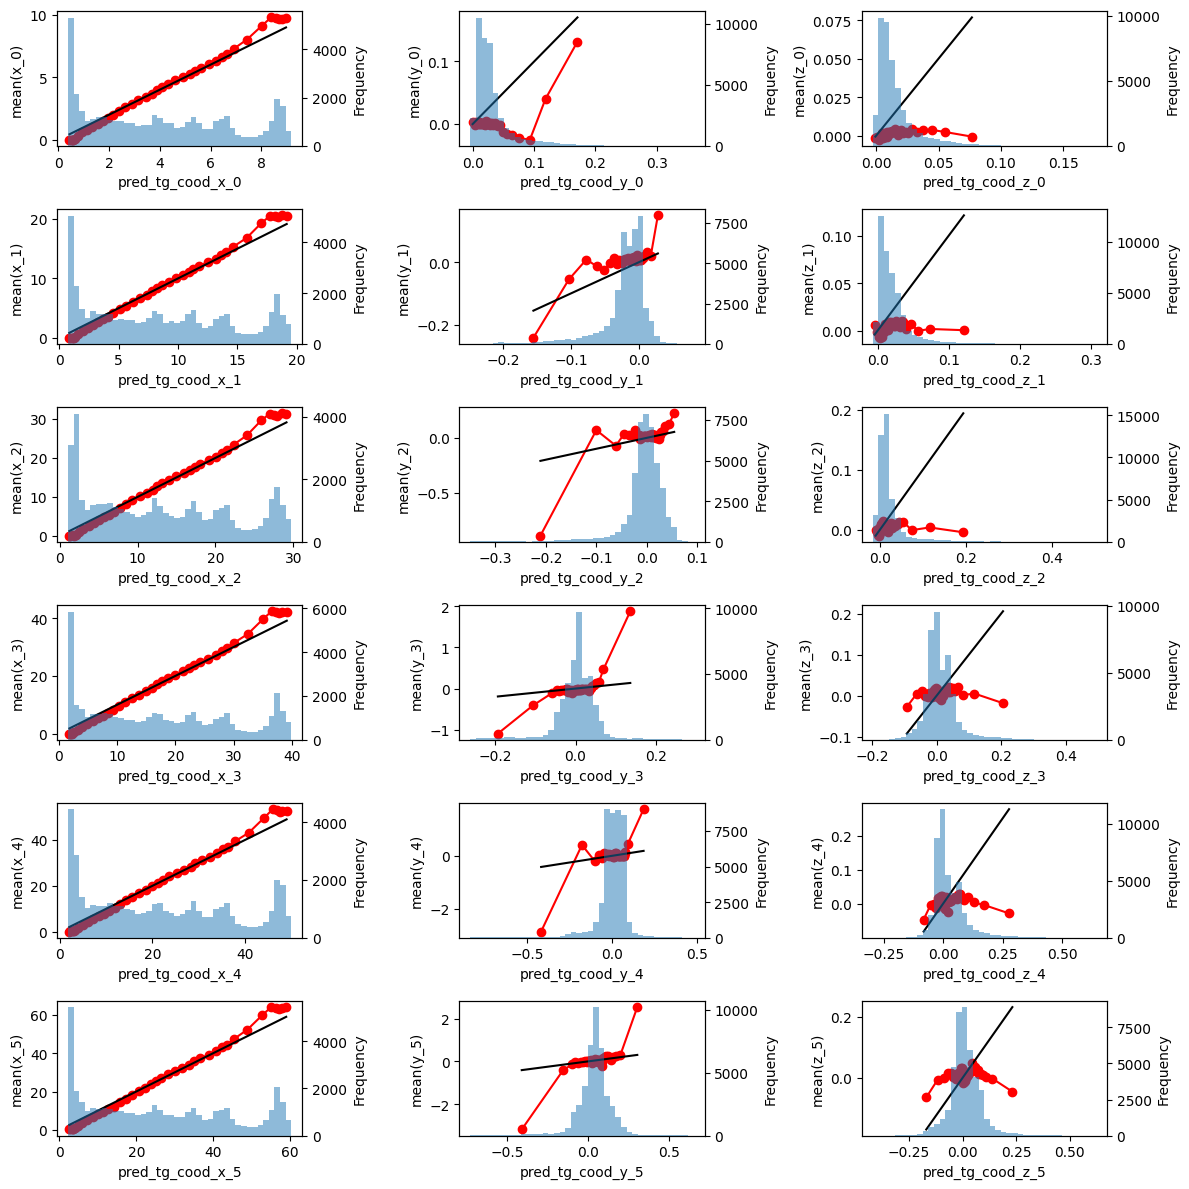

In [15]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## Submission

In [16]:
preds = utils.predict(models, ts_images, ts_df, feature.columns, pred_cols)
preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.537985,0.002534,0.001622,3.258337,-0.015609,0.006717,4.934452,-0.029619,0.005199,6.685466,-0.028021,-0.00613,8.291311,-0.035578,0.008606,9.968146,-0.095362,0.000884
1.86349,0.128032,0.054013,4.034837,-0.13625,0.066148,6.482864,-0.086453,0.071394,8.283041,-0.040412,0.038243,10.852889,-0.132061,0.068485,12.797792,-0.094715,-0.01383
1.661354,0.006483,0.000963,3.529406,-0.011252,0.008153,5.329331,-0.020314,0.004543,7.28983,-0.019624,-0.002352,9.034515,-0.046926,0.006839,10.704288,-0.08501,0.008093
1.266506,0.039006,0.018644,2.648292,-0.045916,0.010778,4.128186,-0.03194,0.01058,5.409149,-0.029861,-0.011216,6.888872,-0.06082,-0.01344,8.336949,-0.040561,-0.039875
1.048774,0.019059,0.008976,2.220839,-0.034445,0.005617,3.459049,-0.026541,0.012359,4.590037,-0.019536,-0.002871,5.67336,-0.052453,-0.002098,6.825492,-0.045227,-0.01874
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6.493193,0.038225,0.023263,13.75122,-0.015377,0.038386,20.938326,0.000807,0.03974,28.142309,-0.00371,0.029302,35.44545,0.02403,0.052524,42.566698,0.078019,0.046662
7.002677,0.032432,0.019499,14.841627,-0.019138,0.030438,22.607987,-0.013617,0.026604,30.47708,0.006517,0.024185,38.370765,-0.004956,0.030757,45.927956,0.02664,0.022529
7.464785,0.027576,0.015373,15.851515,-0.017155,0.023561,24.174632,-0.008768,0.018211,32.594418,0.013637,0.021663,40.995718,-0.003173,0.023325,49.145374,0.022877,0.016717


In [17]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


create_submission_csv(preds)

Submission file is created: submission.csv
